In [2]:
! pwd

/home/bsherwin51/Renaissance/RP


In [3]:
import h5py as h

In [4]:
ds = h.File('catalog.h5')
print(ds)

<HDF5 file "catalog.h5" (mode r)>


In [6]:
print(len(ds.keys())) # only 168 halos now

168


In [7]:
for key in ds.keys():
    print(ds[key].keys())
    break

<KeysViewHDF5 ['M_HI', 'M_HII', 'Mstar', 'Mstar_pop2', 'Mstar_pop2_young', 'Mstar_pop3', 'Nesc', 'Ntot', 'NumberOfPop2Stars', 'NumberOfPop3Stars', 'SFR', 'center', 'fesc', 'fgas', 'fstar', 'mass', 'redshift', 'rvir']>


In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
all_groups = {}
fescs = []
groups = []
fgases = []
masses = []
SFRs = [] 
Mstars = []
redshifts = []
for halo in ds.keys(): # loops through halos
    fesc_list = list(ds[halo]['fesc'])
    fgas_list = list(ds[halo]['fgas'])
    mass_list = list(ds[halo]['mass'])
    SFR_list = list(ds[halo]['SFR'])
    Mstar_list = list(ds[halo]['Mstar'])
    redshift_list = list(ds[halo]['redshift'])    
    for index, fesc in enumerate(fesc_list):# loops thru timestep
        if fesc <= 0.01:
            group = 0
        elif 0.01 < fesc <= 0.10:
            group = 1
        elif 0.10 < fesc <= 0.25:
            group = 2
        else:
            group = 3
        # used enumerate to find index and only use "good" values
        if fesc >= 1e-5:
            fescs.append(fesc)
            groups.append(group)
            fgases.append(ds[halo]['fgas'][index])
            masses.append(ds[halo]['mass'][index])
            SFRs.append(ds[halo]['SFR'][index])
            Mstars.append(ds[halo]['Mstar'][index])
            redshifts.append(ds[halo]['redshift'][index])
    all_groups[halo] = groups

# Sanity check: All parameter arrays should be same size
print(len(fescs), len(fgases), len(masses), len(SFRs), len(Mstars), len(redshifts)) # length is 3122 for all

# Sanity check 2: Length of all_groups should be same as number of halos
print(len(ds.keys()) == len(all_groups)) # length is 168




2139 2139 2139 2139 2139 2139
True


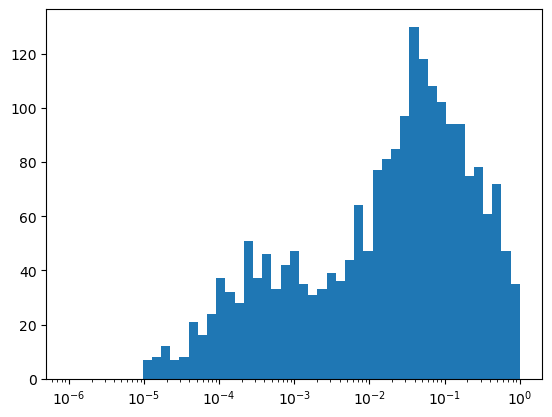

In [14]:
plt.hist(fescs, bins = np.logspace(-6, 0))
plt.xscale('log')

## Architecture

In [15]:
import torch 
import torch.nn as nn
import numpy as np
import sys, os, tAime
import optuna # Optimizer

In [16]:
# 1 hidden layer code

# inp ---------> size of input data
# h1 ----------> size of first hidden layer
# out ---------> size of output data
# dr ----------> dropout rate
class model_1hl(nn.Module):
    
    def __init__(self, inp, h1, out, dr):
        super(model_1hl, self).__init__()

        self.fc1 = nn.Linear(inp, h1) # lin trans
        self.fc2 = nn.Linear(h1,  out)
        
        self.dropout   = nn.Dropout(p=dr) #normalizes by zeroing at random
        self.ReLU      = nn.ReLU() # RELU(x) = max(0,x)
        self.LeakyReLU = nn.LeakyReLU(0.2) # LeakyReLU = max(0,x) + neg_slope * min(0,x)
        
        # initialize the weights of the different layers
        for m in self.modules(): 
            if isinstance(m, nn.BatchNorm3d) or isinstance(m, nn.BatchNorm1d): # if module is Batch normalization: y = gamma*(x -  E(x))/sqrt(Var(x) + eps) + b
                nn.init.constant_(m.weight, 1) 
                nn.init.constant_(m.bias, 1)
            elif isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
                 '''if module is 3D Convolution: over an input signal composed of several input planes. or ConvTranspose2d Applies a 3D transposed convolution operator over an input image composed of several input planes. The transposed convolution operator multiplies each input value element-wise by a learnable kernel, and sums over the outputs from all input feature planes. Or Lin Trans'''
                 nn.init.kaiming_normal_(m.weight) # normalization that makes extremely deep models (>30 layers) to converge
       
    # forward pass
    def forward(self, x):
        out = self.dropout(self.LeakyReLU(self.fc1(x))) # Apply leakyRELU on input and dropout normalize
        out = self.fc2(out) 
        # out = nn.Softmax(out)
        return out


In [17]:
# N hidden layer code, similar structure to above but generalized
def dynamic_model2(input_size, output_size, n_layers, hidden, dr):

    # define the tuple containing the different layers
    layers = []

    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = hidden[i]
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        layers.append(nn.Dropout(dr[i]))
        in_features = out_features

    # get the last layer
    layers.append(nn.Linear(out_features, output_size))

    # return the model
    return nn.Sequential(*layers)

#model = dynamic_model2(numFeatures, outSize, numHL, [h1, h2], [dr1, dr1])

## Data

In [18]:
from random import shuffle
import torch 
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import numpy as np
import sys, os, time, h5py
from pathlib import Path

In [19]:
def normalize_data(data, labels):
    ######################
    # normalize input
    ## the id's correspond to the id's of the feature array you made using vstack in read_data()
    data[:,0]  = (data[:,0] - np.mean(data[:,0]))/np.std(data[:,0]) # Z Scores
    data[:,1]  = (data[:,1] - np.mean(data[:,1]))/np.std(data[:,1])
    data[:,2]  = (data[:,2] - np.mean(data[:,2]))/np.std(data[:,2])
    data[:,3]  = (data[:,3] - np.mean(data[:,3]))/np.std(data[:,3])
    data[:,4]  = (data[:,4] - np.mean(data[:,4]))/np.std(data[:,4])

    ######################
    # normalize labels
    print ("labels", labels)

    # # array = np.log10(labels) # Since labels are large log them
    # print("labels array", array)
    # labels = array
    
    return data, labels

In [20]:
# read data and get training, validation or testing sets
# fin ---------> file with the data
# seed --------> random seed used to split among different datasets
# mode --------> 'train', 'valid', 'test' or 'all'
# normalize ---> whether to normalize the data or not
def read_data(fin, seed, mode, normalize): #fin for h5
    File = 'catalog.h5'
    f     = h5py.File(fin, 'r')
    masses = []
    fgases = []
    SFRs = []
    Mstars = []
    redshifts = []
    fescs = []
    groups = []
    for halo in f.keys():
        fesc_list = list(f[halo]['fesc']) 
        for index, fesc in enumerate(fesc_list):
            if fesc <= 0.01:
                group = 0
            elif 0.01 < fesc <= 0.10:
                group = 1
            elif 0.10 < fesc <= 0.25:
                group = 2
            else:
                group = 3
                
            if fesc >= 1e-5:
                masses.append(f[halo]['mass'][index])
                fgases.append(f[halo]['fgas'][index])
                SFRs.append(f[halo]['SFR'][index])
                Mstars.append(f[halo]['Mstar'][index])
                redshifts.append(f[halo]['redshift'][index])
                fescs.append(fesc)
                groups.append(group)  
    # min_SFR = np.min(SFRs[SFRs != 0])
    minsfr = 100
    for each in SFRs:
        if each < minsfr and each != 0.:
            minsfr = each
    new_SFRs = []
    for SFR in SFRs:
        if SFR == 0.0:
            new_SFRs.append(minsfr*0.9)
        else:
            new_SFRs.append(SFR)        
    # normalize data - EDIT
    ## anything not on order 10^0 - 10^1 should be logged
    masses = np.log10(masses)
    SFRs = np.log10(new_SFRs)
    Mstars = np.log10(Mstars)
    fgases = np.log10(fgases)
    
    # get data, labels and number of elements
    data = np.vstack([SFRs, Mstars, masses, redshifts, fgases]).T # THESE ARE YOUR CHOSEN INPUT VARIABLES
    
    labels = np.array(groups, dtype = 'int')
    print("labels.shape", labels.shape)
    # labels = fluxes.reshape((fluxes.shape[0], fluxSize))
    elements = data.shape[0]
    
    # normalize data
    if normalize:  data, labels = normalize_data(data, labels)

    # get the size and offset depending on the type of dataset
    if   mode=='train':   size, offset = int(elements*0.70), int(elements*0.00)
    elif mode=='valid':   size, offset = int(elements*0.15), int(elements*0.70)
    elif mode=='test':    size, offset = int(elements*0.15), int(elements*0.85)
    elif mode=='all':     size, offset = int(elements*1.00), int(elements*0.00)
    else:                 raise Exception('Wrong name!')

    # randomly shuffle the cubes. Instead of 0 1 2 3...999 have a 
    # random permutation. E.g. 5 9 0 29...342
    np.random.seed(seed)
    indexes = np.arange(elements) 
    np.random.shuffle(indexes)
    indexes = indexes[offset:offset+size] #select indexes of mode

    return data[indexes], labels[indexes]



In [21]:
class make_dataset():

    def __init__(self, mode, seed, fin):

        # get data
        inp, out = read_data(fin, seed, mode, normalize=True)

        # get the corresponding bottlenecks and parameters
        self.size   = inp.shape[0]
        self.input  = torch.tensor(inp, dtype=torch.float32)
        self.output = torch.tensor(out, dtype= torch.long)
        
        print ("size of input and output", np.shape(self.input), np.shape(self.output))
        
    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        return self.input[idx], self.output[idx]

In [22]:
def create_dataset(mode, seed, fin, batch_size, shuffle):
    data_set = make_dataset(mode, seed, fin)
    dataset_loader = DataLoader(dataset=data_set, batch_size=batch_size, shuffle=shuffle)
    return dataset_loader

## Main

In [56]:
fin = 'catalog.h5'
dataname = 'RP'      # Nickname for data
seed = 20                # remember this to reproduce split
numFeatures = 5         # number of input properties
outSize = 4          # size of wavelength array
featurelist = 'SFRs, Mstars, masses, redshifts, fgases'

# OPTUNA HYPERPARMETERS
numHL = 4           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_1 = 333           # nodes in second hidden layer
h2_1 = 396
h3_1 = 85
h4_1 = 423
dr1_1 = 0.493895281796021
dr2_1 = 0.3460606793747979
dr3_1 = 0.24913962166483994
dr4_1 = 0.3978684708092593
lr_1 = 0.0009539903601749256
wd_1 = 0.009344986387296987

Trial 47 finished with value: 0.8576046586036682 and parameters: {'n_layers': 4, 'n_units_l0': 333, 'dropout_l0': 0.493895281796021, 'n_units_l1': 396, 'dropout_l1': 0.3460606793747979, 'n_units_l2': 85, 'dropout_l2': 0.24913962166483994, 'n_units_l3': 423, 'dropout_l3': 0.3978684708092593, 'lr': 0.0009539903601749256, 'wd': 0.009344986387296987}. Best is trial 47 with value: 0.8576046586036682.

In [73]:
# OPTUNA HYPERPARMETERS
numHL = 4           # number of hidden layers
# h1 = 954                # nodes in first hidden layer
h1_2 = 462           # nodes in second hidden layer
h2_2 = 482
h3_2 = 189
h4_2 = 381
dr1_2 = 0.4864343558320114
dr2_2 = 0.307569229312319
dr3_2 = 0.2633390537317342
dr4_2 = 0.3584793881173535
lr_2 = 0.0008946090999908592
wd_2 = 0.005752129050507543

Trial 44 finished with value: 0.879888904094696 and parameters: {'n_layers': 4, 'n_units_l0': 462, 'dropout_l0': 0.4864343558320114, 'n_units_l1': 482, 'dropout_l1': 0.3075692293123195, 'n_units_l2': 189, 'dropout_l2': 0.2633390537317342, 'n_units_l3': 381, 'dropout_l3': 0.3584793881173535, 'lr': 0.0008946090999908592, 'wd': 0.005752129050507543}. Best is trial 44 with value: 0.879888904094696.

In [74]:
num_HL_3 = 3
h1_3 = 417           # nodes in second hidden layer
h2_3 = 355
h3_3 = 217
dr1_3 = 0.5972764016330773
dr2_3 = 0.20543964034999765
dr3_3 = 0.28705254287957593
lr_3 = 0.0005841898787632884
wd_3 = 0.002022271824771725

Trial 37 finished with value: 0.8831483840942382 and parameters: {'n_layers': 3, 'n_units_l0': 417, 'dropout_l0': 0.5972764016330773, 'n_units_l1': 355, 'dropout_l1': 0.20543964034999765, 'n_units_l2': 217, 'dropout_l2': 0.28705254287957593, 'lr': 0.0005841898787632884, 'wd': 0.002022271824771725}. Best is trial 37 with value: 0.8831483840942382.

In [75]:
h1_non = 150
h2_non = 150
numHL_non = 2
# # # dr1 = 0.20103              # dropout rate for layer 1
dr1_non = 0.35
# # # training parameters
batch_size = 256
# # # lr         = 1.404e-3     (learning rate)
lr_non = 0.01
epochs     = 1000
# # # wd         = 1.195e-6
wd_non = 0

In [60]:
# name of output files


name   = "Normal_dynamicmodel2"
device = torch.device('cpu')
# define loss function
criterion = nn.CrossEntropyLoss()  # MSE or Cross Entropy

# get train, validation, and test sets
print('preparing dataset...')
train_loader = create_dataset('train', seed, fin, batch_size, True)
valid_loader = create_dataset('valid', seed, fin, batch_size, False)
test_loader  = create_dataset('test',  seed, fin, batch_size, False)



preparing dataset...
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


In [80]:
#model_non = dynamic_model2(numFeatures, outSize, numHL_non, [h1_non, h2_non], [dr1_non, dr1_non])
model = dynamic_model2(numFeatures, outSize, num_HL_3, [h1_3, h2_3, h3_3], [dr1_3, dr2_3, dr3_3])

In [81]:
fout   = 'test_optuna3.txt'
fmodel = 'test_optuna3.pt'
#casts parameters/buffers to specified gpu
model.to(device=device)
#get num elements in each network parameters and sum them
network_total_params = sum(p.numel() for p in model.parameters())
print('total number of parameters in the model = %d'%network_total_params)

# define optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_3, betas=(0.5, 0.999), 
                             weight_decay=wd_3)	


# load best-model, if it exists
'''
if os.path.exists(fmodel):  
    print('Loading model...')
    model.load_state_dict(torch.load(fmodel))
# get validation loss
print('Computing initial validation loss')
model.eval()
min_valid_loss, points = 0.0, 0
for x, y in valid_loader:
    with torch.no_grad():
        x    = x.to(device=device)
        y    = y.to(device=device)
        y_NN = model(x)
        min_valid_loss += (criterion(y_NN, y).item())*x.shape[0]
        points += x.shape[0]
min_valid_loss /= points
print('Initial valid loss = %.3e'%min_valid_loss)
'''
# see if results for this model are available (if you're continuing training on a model)
'''
if os.path.exists(fout):  
    dumb = np.loadtxt(fout, skiprows = 11, unpack=False)
    if dumb.size == 0:
        offset = 0
    else: offset = int(dumb[:,0][-1]+1)
else:   offset = 0
'''

# do a loop over all epochs
start = time.time()
min_valid_loss = 1000
for epoch in range(epochs):
    # do training
    train_loss, points = 0.0, 0
    model.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_NN = model(x)
        #y = nn.Softmax(y)
        #y_NN = nn.Softmax(y_NN)
        loss = criterion(y_NN, y)
        train_loss += (loss.item())*x.shape[0]
        points     += x.shape[0]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= points

    # do testing
    test_loss, points = 0.0, 0
    model.eval()
    for x, y in test_loader:
        with torch.no_grad():
            x    = x.to(device)
            y    = y.to(device)
            #y = nn.Softmax(y)
            y_NN = model(x)
            #y_NN = nn.Softmax(y_NN)
            test_loss += (criterion(y_NN, y).item())*x.shape[0]
            points    += x.shape[0]
    test_loss /= points
    
    # save model if it is better
    if test_loss<min_valid_loss:
        torch.save(model.state_dict(), fmodel)
        min_valid_loss = test_loss
        print('%03d %.3e %.3e (saving)'%(epoch, train_loss, test_loss))
    else:
        print('%03d %.3e %.3e'%(epoch, train_loss, test_loss))
    
    # save losses to file
    f = open(fout, 'a')
    f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
    f.close()
    
stop = time.time()
print('Time take (m):', "{:.4f}".format((stop-start)/60.0))

total number of parameters in the model = 229016
000 1.293e+00 1.178e+00 (saving)
001 1.146e+00 1.095e+00 (saving)
002 1.104e+00 1.075e+00 (saving)
003 1.088e+00 1.056e+00 (saving)
004 1.075e+00 1.045e+00 (saving)
005 1.068e+00 1.039e+00 (saving)
006 1.051e+00 1.035e+00 (saving)
007 1.051e+00 1.030e+00 (saving)
008 1.046e+00 1.019e+00 (saving)
009 1.033e+00 1.026e+00
010 1.035e+00 1.014e+00 (saving)
011 1.033e+00 1.009e+00 (saving)
012 1.029e+00 1.009e+00
013 1.026e+00 1.010e+00
014 1.029e+00 1.012e+00
015 1.016e+00 1.022e+00
016 1.018e+00 1.001e+00 (saving)
017 1.021e+00 1.004e+00
018 1.020e+00 1.005e+00
019 1.023e+00 1.004e+00
020 1.012e+00 1.005e+00
021 1.015e+00 1.004e+00
022 1.018e+00 1.002e+00
023 1.015e+00 1.003e+00
024 1.019e+00 1.000e+00 (saving)
025 1.010e+00 9.938e-01 (saving)
026 1.003e+00 9.993e-01
027 1.018e+00 1.016e+00
028 1.009e+00 9.986e-01
029 1.001e+00 9.944e-01
030 9.968e-01 9.955e-01
031 1.005e+00 9.945e-01
032 9.999e-01 9.940e-01
033 1.011e+00 9.915e-01 (saving)


In [82]:
losses_1 = np.loadtxt('test_optuna1.txt', delimiter = ' ')
train_losses_1 = losses_1[:,1]
test_losses_1 = losses_1[:, 2]

losses_2 = np.loadtxt('test_optuna2.txt', delimiter = ' ')
train_losses_2 = losses_2[:,1]
test_losses_2 = losses_2[:, 2]

losses_3 = np.loadtxt('test_optuna3.txt', delimiter = ' ')
train_losses_3 = losses_3[:,1]
test_losses_3 = losses_3[:, 2]

# losses_non = np.loadtxt('test_non.txt', delimiter = ' ')
# train_losses_non = losses_non[:,1]
# test_losses_non = losses_non[:, 2]

Text(0, 0.5, 'Loss')

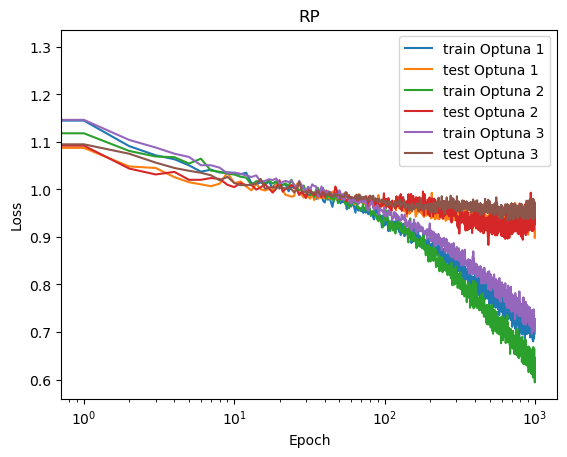

In [83]:
import matplotlib.pyplot as plt
plt.plot(train_losses_1, label = 'train Optuna 1')
plt.plot(test_losses_1, label = 'test Optuna 1')
plt.plot(train_losses_2, label = 'train Optuna 2')
plt.plot(test_losses_2, label = 'test Optuna 2')
plt.plot(train_losses_3, label = 'train Optuna 3')
plt.plot(test_losses_3, label = 'test Optuna 3')
# plt.plot(train_losses_non, label = 'train no Optuna')
# plt.plot(test_losses_non, label = 'test no Optuna')
plt.xscale('log')
#plt.xlim(100,1000)
plt.legend()
plt.title("RP")
plt.xlabel("Epoch")
plt.ylabel("Loss")

## Optuna

In [32]:
def dynamic_model(trial, input_size, output_size, max_layers=3, max_neurons_layers=500):
    # define the tuple containing the different layers
    layers = []
    # get the number of hidden layers
    n_layers = trial.suggest_int("n_layers", 1, max_layers)
    # get the hidden layers
    in_features = input_size
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, max_neurons_layers)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.LeakyReLU(0.2))
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.8)
        layers.append(nn.Dropout(p))
        in_features = out_features
    # get the last layer
    layers.append(nn.Linear(out_features, output_size))
    # return the model
    return nn.Sequential(*layers)

In [33]:
import numpy as np
import sys, os, time
import torch
import torch.nn as nn
import optuna
import h5py

In [34]:
class Objective(object):
    def __init__(self, input_size, output_size, max_layers, max_neurons_layers, device,
                 epochs, seed, batch_size):

        self.input_size         = input_size
        self.output_size        = output_size
        self.max_layers         = max_layers
        self.max_neurons_layers = max_neurons_layers
        self.device             = device
        self.epochs             = epochs
        self.seed               = seed
        self.batch_size         = batch_size

    def __call__(self, trial):

        # name of the files that will contain the losses and model weights
        f1 = 'losses_%s'%prefix
        f2 = 'models_%s'%prefix
        if not(os.path.exists(f1)):  os.system('mkdir %s'%f1)
        if not(os.path.exists(f2)):  os.system('mkdir %s'%f2)

        fout   = 'losses_%s/loss_%d.txt'%(prefix, trial.number)
        fmodel = 'models_%s/model_%d.pt'%(prefix, trial.number)
        
        dataname = 'fesc_test' # name of your dataset, for the loss file header
        
        # write properties & headers in case you need to refer in the future and you've changed the main.py file
        f = open(fout, 'w')
        f.write('training dataset: {}\n'.format(dataname))
        f.write('seed = {}\numFeatures = {}\nFeature List: {}\nfluxSize = {}\nbatch_size = {}\nepochs     = {}\n'.format(seed, input_size, features, output_size, batch_size, epochs))
        f.write('0 epoch  1 train loss  2 test loss\n')
        f.close()

        # generate the architecture
        model = dynamic_model(trial, self.input_size, self.output_size, 
                            self.max_layers, self.max_neurons_layers).to(self.device)

        # get the weight decay and learning rate values
        ## adjust boundary values as needed
        lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
        wd = trial.suggest_float("wd", 1e-8, 1e-2,  log=True)

        # define the optimizer
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, betas=(0.5, 0.999), 
                                      weight_decay=wd)

        # define loss function
        criterion = nn.CrossEntropyLoss() 

        # get the data
        train_loader = create_dataset('train', self.seed, fin, self.batch_size, True)
        valid_loader = create_dataset('valid', self.seed, fin, self.batch_size, False)
        test_loader  = create_dataset('test',  self.seed, fin, self.batch_size, False)

        # train/validate model
        min_valid = 1e40
        for epoch in range(self.epochs):

            # training
            train_loss, points = 0.0, 0
            model.train()
            for x, y in train_loader:
                x, y = x.to(self.device), y.to(self.device)
                y_NN = model(x)
                
                loss = criterion(y_NN, y)
                train_loss += (loss.item())*x.shape[0]
                points     += x.shape[0]
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            train_loss /= points
            '''
            # validation
            valid_loss, points = 0.0, 0
            model.eval()
            with torch.no_grad():
                for x, y in valid_loader:
                    x, y = x.to(self.device), y.to(self.device)
                    y_NN = model(x)
                    valid_loss += (criterion(y_NN, y).item())*x.shape[0]
                    points     += x.shape[0]
            valid_loss /= points
            '''
            # do testing
            test_loss, points = 0.0, 0
            model.eval()
            for x, y in test_loader:
                with torch.no_grad():
                    x    = x.to(device)
                    y    = y.to(device)
                    y_NN = model(x)
                    test_loss += (criterion(y_NN, y).item())*x.shape[0]
                    points    += x.shape[0]
            test_loss /= points
            
            #save this model if it's better
            if test_loss<min_valid:  
                min_valid = test_loss
                torch.save(model.state_dict(), fmodel)
            f = open(fout, 'a')
            f.write('%d %.5e %.5e\n'%(epoch, train_loss, test_loss))
            f.close()

            # Handle pruning based on the intermediate value
            # comment out these lines if using pruning
            #trial.report(min_valid, epoch)
            #if trial.should_prune():  raise optuna.exceptions.TrialPruned()

        return min_valid


In [36]:
##################################### INPUT ##########################################
# data parameters
fin      = 'catalog.h5' # file containing your global properties
features = 'SFRs, Mstars, masses, redshifts, fgases' # writing the order of input data as per data.py. Modify as needed
f_features_norm = None
f_labels  = 'fesc_test.txt' # file containing output SEDs
seed      = 5

# optuna architecture parameters
input_size         = 5 # number of input global properties
output_size        = 4 # size of SED/wavelength array
max_layers         = 5 # max number of hidden layers to test out
max_neurons_layers = 500 # max number of nodes per hidden layer to test out

# training parameters
batch_size = 256
epochs     = 1000

# optuna parameters -- modify as needed
prefix    = 'inp{}out{}maxl{}maxn{}bs{}ep{}'.format(input_size, output_size, max_layers, max_neurons_layers, batch_size, epochs)
study_name       = 'fesc' 
n_trials         = 50 # set to None for infinite
storage          = 'sqlite:///fesc_%s.db'%prefix 
n_jobs           = 1
n_startup_trials = 30 # random sample the hyperparameter space before running the model sampler
#########################


In [37]:
device = torch.device('cpu')

# define the optuna study and optimize it
objective = Objective(input_size, output_size, max_layers, max_neurons_layers, 
                      device, epochs, seed, batch_size)
sampler = optuna.samplers.TPESampler(n_startup_trials=n_startup_trials)
study = optuna.create_study(study_name=study_name, sampler=sampler, storage=storage,
                            load_if_exists=True)
study.optimize(objective, n_trials, n_jobs=n_jobs)


[I 2023-06-01 14:39:35,058] A new study created in RDB with name: fesc


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 14:41:30,231] Trial 0 finished with value: 0.9908517956733703 and parameters: {'n_layers': 2, 'n_units_l0': 321, 'dropout_l0': 0.6054446903846836, 'n_units_l1': 151, 'dropout_l1': 0.7910815194363812, 'lr': 0.00018914244384543472, 'wd': 1.4799737582026373e-06}. Best is trial 0 with value: 0.9908517956733703.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 14:45:52,352] Trial 1 finished with value: 0.9938820123672485 and parameters: {'n_layers': 2, 'n_units_l0': 376, 'dropout_l0': 0.4866170464257742, 'n_units_l1': 454, 'dropout_l1': 0.5092472463802711, 'lr': 4.210373696716956e-05, 'wd': 0.0031827687153190985}. Best is trial 0 with value: 0.9908517956733703.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 14:48:29,392] Trial 2 finished with value: 0.9671885371208191 and parameters: {'n_layers': 1, 'n_units_l0': 358, 'dropout_l0': 0.3268890374523211, 'lr': 0.0011000853711779061, 'wd': 0.004479202454349285}. Best is trial 2 with value: 0.9671885371208191.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 14:52:39,306] Trial 3 finished with value: 0.9711811304092407 and parameters: {'n_layers': 5, 'n_units_l0': 32, 'dropout_l0': 0.25488647228443306, 'n_units_l1': 138, 'dropout_l1': 0.3600988902434257, 'n_units_l2': 381, 'dropout_l2': 0.37235594626030055, 'n_units_l3': 360, 'dropout_l3': 0.5500254643461839, 'n_units_l4': 439, 'dropout_l4': 0.3432516719165424, 'lr': 0.00012662664395466568, 'wd': 1.4792525414331795e-05}. Best is trial 2 with value: 0.9671885371208191.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 14:55:58,638] Trial 4 finished with value: 1.0175493240356446 and parameters: {'n_layers': 5, 'n_units_l0': 69, 'dropout_l0': 0.6842740252223485, 'n_units_l1': 63, 'dropout_l1': 0.796896056671236, 'n_units_l2': 145, 'dropout_l2': 0.5991538144865378, 'n_units_l3': 255, 'dropout_l3': 0.26541545314196013, 'n_units_l4': 221, 'dropout_l4': 0.2615919462929631, 'lr': 0.00032572000935918453, 'wd': 6.408604850971561e-08}. Best is trial 2 with value: 0.9671885371208191.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:00:15,157] Trial 5 finished with value: 0.9678496360778809 and parameters: {'n_layers': 4, 'n_units_l0': 347, 'dropout_l0': 0.2366460359500553, 'n_units_l1': 223, 'dropout_l1': 0.24990948951944822, 'n_units_l2': 361, 'dropout_l2': 0.6454936763463625, 'n_units_l3': 70, 'dropout_l3': 0.5248140575276128, 'lr': 3.290673174193472e-05, 'wd': 1.0183560778723122e-05}. Best is trial 2 with value: 0.9671885371208191.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:03:51,345] Trial 6 finished with value: 0.993437671661377 and parameters: {'n_layers': 2, 'n_units_l0': 452, 'dropout_l0': 0.5016948258297205, 'n_units_l1': 235, 'dropout_l1': 0.6147350379804917, 'lr': 4.997131554928532e-05, 'wd': 1.5715672831180507e-06}. Best is trial 2 with value: 0.9671885371208191.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:09:13,540] Trial 7 finished with value: 0.9403188467025757 and parameters: {'n_layers': 4, 'n_units_l0': 445, 'dropout_l0': 0.6783256627864593, 'n_units_l1': 110, 'dropout_l1': 0.7212680772672682, 'n_units_l2': 389, 'dropout_l2': 0.21223020484710314, 'n_units_l3': 106, 'dropout_l3': 0.635258494903447, 'lr': 0.002884682518020777, 'wd': 7.388598768076409e-07}. Best is trial 7 with value: 0.9403188467025757.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:10:54,007] Trial 8 finished with value: 1.067568016052246 and parameters: {'n_layers': 1, 'n_units_l0': 108, 'dropout_l0': 0.719937269694332, 'lr': 4.0508844971279915e-05, 'wd': 0.008556343226110284}. Best is trial 7 with value: 0.9403188467025757.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:12:21,235] Trial 9 finished with value: 1.0187645196914672 and parameters: {'n_layers': 2, 'n_units_l0': 131, 'dropout_l0': 0.3174119426314261, 'n_units_l1': 212, 'dropout_l1': 0.6641933190795741, 'lr': 2.5773242716255906e-05, 'wd': 6.844729507602362e-05}. Best is trial 7 with value: 0.9403188467025757.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:16:41,940] Trial 10 finished with value: 0.9214498996734619 and parameters: {'n_layers': 4, 'n_units_l0': 363, 'dropout_l0': 0.7238880149960072, 'n_units_l1': 419, 'dropout_l1': 0.2316727465528458, 'n_units_l2': 368, 'dropout_l2': 0.240412370783416, 'n_units_l3': 351, 'dropout_l3': 0.5405792448828385, 'lr': 0.000279471811024033, 'wd': 0.0014528768678589736}. Best is trial 10 with value: 0.9214498996734619.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:19:54,799] Trial 11 finished with value: 0.9189357042312623 and parameters: {'n_layers': 3, 'n_units_l0': 356, 'dropout_l0': 0.3201422665804159, 'n_units_l1': 277, 'dropout_l1': 0.4209976922237951, 'n_units_l2': 304, 'dropout_l2': 0.622947241978854, 'lr': 0.007404565163110751, 'wd': 2.0209515177211843e-05}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:21:07,999] Trial 12 finished with value: 0.9457665920257569 and parameters: {'n_layers': 1, 'n_units_l0': 346, 'dropout_l0': 0.20482719425883947, 'lr': 0.001504526221239777, 'wd': 2.246659677252817e-05}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:22:50,298] Trial 13 finished with value: 0.999496579170227 and parameters: {'n_layers': 5, 'n_units_l0': 64, 'dropout_l0': 0.460594575602131, 'n_units_l1': 67, 'dropout_l1': 0.6547008558191667, 'n_units_l2': 34, 'dropout_l2': 0.22562799803547942, 'n_units_l3': 160, 'dropout_l3': 0.7982331099438205, 'n_units_l4': 136, 'dropout_l4': 0.5072377301364194, 'lr': 0.00016607136687199118, 'wd': 4.593541429879169e-07}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:23:52,383] Trial 14 finished with value: 1.1295795917510987 and parameters: {'n_layers': 1, 'n_units_l0': 55, 'dropout_l0': 0.6812004906198534, 'lr': 1.897715231017737e-05, 'wd': 5.641100524110544e-06}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:25:22,433] Trial 15 finished with value: 0.9867534160614013 and parameters: {'n_layers': 4, 'n_units_l0': 65, 'dropout_l0': 0.337695289963861, 'n_units_l1': 252, 'dropout_l1': 0.7561494564898683, 'n_units_l2': 28, 'dropout_l2': 0.42269734161286565, 'n_units_l3': 61, 'dropout_l3': 0.7701732000281207, 'lr': 0.00016585384965377966, 'wd': 3.3899691757285457e-07}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:26:35,062] Trial 16 finished with value: 1.007266342639923 and parameters: {'n_layers': 1, 'n_units_l0': 257, 'dropout_l0': 0.7661273766941465, 'lr': 0.007315004816931705, 'wd': 1.9490494355577046e-08}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:28:39,653] Trial 17 finished with value: 0.9611451268196106 and parameters: {'n_layers': 2, 'n_units_l0': 310, 'dropout_l0': 0.5490318390042462, 'n_units_l1': 360, 'dropout_l1': 0.5180965702050429, 'lr': 0.00019530671484049842, 'wd': 1.3929946008582976e-06}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:30:38,496] Trial 18 finished with value: 1.046346867084503 and parameters: {'n_layers': 3, 'n_units_l0': 15, 'dropout_l0': 0.7790903024188012, 'n_units_l1': 418, 'dropout_l1': 0.6192868812919283, 'n_units_l2': 423, 'dropout_l2': 0.35274326619885354, 'lr': 0.0045675345504801665, 'wd': 3.075553681348502e-05}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:32:20,105] Trial 19 finished with value: 0.9723074197769165 and parameters: {'n_layers': 4, 'n_units_l0': 123, 'dropout_l0': 0.6753167735940795, 'n_units_l1': 428, 'dropout_l1': 0.6590567586102442, 'n_units_l2': 192, 'dropout_l2': 0.7438131672798192, 'n_units_l3': 23, 'dropout_l3': 0.3978866471280682, 'lr': 0.00040843523262401577, 'wd': 5.244584095403542e-07}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:33:56,355] Trial 20 finished with value: 1.0776890635490417 and parameters: {'n_layers': 1, 'n_units_l0': 228, 'dropout_l0': 0.6032139066540748, 'lr': 1.1493999793489654e-05, 'wd': 2.169206858137306e-07}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:36:22,310] Trial 21 finished with value: 0.9947215676307678 and parameters: {'n_layers': 5, 'n_units_l0': 280, 'dropout_l0': 0.6425013891334974, 'n_units_l1': 255, 'dropout_l1': 0.4307948546256013, 'n_units_l2': 131, 'dropout_l2': 0.7665402012000142, 'n_units_l3': 241, 'dropout_l3': 0.5715969103288588, 'n_units_l4': 158, 'dropout_l4': 0.44063690604105354, 'lr': 0.006381215989149232, 'wd': 0.00010612286665067847}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:39:12,057] Trial 22 finished with value: 0.9605737328529358 and parameters: {'n_layers': 5, 'n_units_l0': 214, 'dropout_l0': 0.7206583039689507, 'n_units_l1': 324, 'dropout_l1': 0.5135726381752413, 'n_units_l2': 48, 'dropout_l2': 0.2118130707618364, 'n_units_l3': 485, 'dropout_l3': 0.7159364567326454, 'n_units_l4': 364, 'dropout_l4': 0.20699553191480968, 'lr': 0.0002638858784751012, 'wd': 0.009006715912184571}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:40:13,249] Trial 23 finished with value: 0.9909661173820495 and parameters: {'n_layers': 1, 'n_units_l0': 203, 'dropout_l0': 0.5064838539443605, 'lr': 0.0016085355199964907, 'wd': 0.0006202921759741862}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:41:12,481] Trial 24 finished with value: 0.991773784160614 and parameters: {'n_layers': 2, 'n_units_l0': 75, 'dropout_l0': 0.42223247584710544, 'n_units_l1': 87, 'dropout_l1': 0.36276768312683605, 'lr': 0.0002243597539811112, 'wd': 0.00015071562982607554}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:42:56,256] Trial 25 finished with value: 0.9496190547943115 and parameters: {'n_layers': 2, 'n_units_l0': 296, 'dropout_l0': 0.3562134368618909, 'n_units_l1': 444, 'dropout_l1': 0.708365400455842, 'lr': 0.008329051716643396, 'wd': 1.5441707571599029e-07}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:44:12,420] Trial 26 finished with value: 1.0173143863677978 and parameters: {'n_layers': 2, 'n_units_l0': 385, 'dropout_l0': 0.3960003821276838, 'n_units_l1': 140, 'dropout_l1': 0.5415319853126184, 'lr': 1.4743921805635856e-05, 'wd': 0.0001091765071964942}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:45:09,535] Trial 27 finished with value: 1.0753557801246643 and parameters: {'n_layers': 1, 'n_units_l0': 166, 'dropout_l0': 0.2732100858925466, 'lr': 1.5304769935298464e-05, 'wd': 3.738836130423422e-06}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:46:01,258] Trial 28 finished with value: 1.059845495223999 and parameters: {'n_layers': 1, 'n_units_l0': 19, 'dropout_l0': 0.35106352816649694, 'lr': 0.00010440948681844625, 'wd': 0.0037528215084354365}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:46:53,381] Trial 29 finished with value: 1.0410235524177551 and parameters: {'n_layers': 1, 'n_units_l0': 52, 'dropout_l0': 0.6373065529961299, 'lr': 0.00020627127551145136, 'wd': 1.7219700338564447e-07}. Best is trial 11 with value: 0.9189357042312623.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:48:08,963] Trial 30 finished with value: 0.8990158557891845 and parameters: {'n_layers': 3, 'n_units_l0': 480, 'dropout_l0': 0.5807398615650529, 'n_units_l1': 13, 'dropout_l1': 0.20111468445335937, 'n_units_l2': 322, 'dropout_l2': 0.27627148555011627, 'lr': 0.003646465764405212, 'wd': 0.0006608767117643318}. Best is trial 30 with value: 0.8990158557891845.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:49:25,977] Trial 31 finished with value: 0.9059027910232544 and parameters: {'n_layers': 3, 'n_units_l0': 489, 'dropout_l0': 0.6067737625060138, 'n_units_l1': 18, 'dropout_l1': 0.20937426923736213, 'n_units_l2': 305, 'dropout_l2': 0.2633602543030227, 'lr': 0.0037449731692407494, 'wd': 0.00057282751125637}. Best is trial 30 with value: 0.8990158557891845.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:50:45,902] Trial 32 finished with value: 0.9293148756027222 and parameters: {'n_layers': 3, 'n_units_l0': 500, 'dropout_l0': 0.5740914725455236, 'n_units_l1': 8, 'dropout_l1': 0.2046949975054321, 'n_units_l2': 291, 'dropout_l2': 0.32089689589032105, 'lr': 0.00434063965062042, 'wd': 0.0008831239159492563}. Best is trial 30 with value: 0.8990158557891845.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:53:24,658] Trial 33 finished with value: 0.8887063264846802 and parameters: {'n_layers': 3, 'n_units_l0': 412, 'dropout_l0': 0.5468371533110555, 'n_units_l1': 500, 'dropout_l1': 0.2538992303841835, 'n_units_l2': 296, 'dropout_l2': 0.27890498665190583, 'lr': 0.0005523980302426283, 'wd': 0.000709677620551864}. Best is trial 33 with value: 0.8887063264846802.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 15:58:28,034] Trial 34 finished with value: 0.9241447210311889 and parameters: {'n_layers': 3, 'n_units_l0': 439, 'dropout_l0': 0.5508458102305862, 'n_units_l1': 499, 'dropout_l1': 0.2772503140220478, 'n_units_l2': 284, 'dropout_l2': 0.2895402835467297, 'lr': 0.009901480089158763, 'wd': 0.0003685285560000554}. Best is trial 33 with value: 0.8887063264846802.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:00:28,246] Trial 35 finished with value: 0.9311175227165223 and parameters: {'n_layers': 3, 'n_units_l0': 489, 'dropout_l0': 0.5407811606774188, 'n_units_l1': 15, 'dropout_l1': 0.28549481198249316, 'n_units_l2': 305, 'dropout_l2': 0.4484229172454006, 'lr': 0.0027954523863738343, 'wd': 0.000302510308539802}. Best is trial 33 with value: 0.8887063264846802.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:03:44,162] Trial 36 finished with value: 0.8854097962379456 and parameters: {'n_layers': 3, 'n_units_l0': 401, 'dropout_l0': 0.6061095677043123, 'n_units_l1': 296, 'dropout_l1': 0.20348715107043355, 'n_units_l2': 232, 'dropout_l2': 0.301745020260792, 'lr': 0.0005791702295069295, 'wd': 0.0017316356909606125}. Best is trial 36 with value: 0.8854097962379456.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:06:57,321] Trial 37 finished with value: 0.8831483840942382 and parameters: {'n_layers': 3, 'n_units_l0': 417, 'dropout_l0': 0.5972764016330773, 'n_units_l1': 355, 'dropout_l1': 0.20543964034999765, 'n_units_l2': 217, 'dropout_l2': 0.28705254287957593, 'lr': 0.0005841898787632884, 'wd': 0.002022271824771725}. Best is trial 37 with value: 0.8831483840942382.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:09:13,872] Trial 38 finished with value: 0.8848771810531616 and parameters: {'n_layers': 3, 'n_units_l0': 411, 'dropout_l0': 0.5170131579692664, 'n_units_l1': 358, 'dropout_l1': 0.26408650100811415, 'n_units_l2': 222, 'dropout_l2': 0.3016986282148054, 'lr': 0.0007258366282710517, 'wd': 0.001923676411622913}. Best is trial 37 with value: 0.8831483840942382.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:11:22,044] Trial 39 finished with value: 0.9038602709770203 and parameters: {'n_layers': 3, 'n_units_l0': 392, 'dropout_l0': 0.5137754825051929, 'n_units_l1': 356, 'dropout_l1': 0.2780515565818986, 'n_units_l2': 228, 'dropout_l2': 0.33012659475539985, 'lr': 0.0006964244285547533, 'wd': 0.0022591101200106086}. Best is trial 37 with value: 0.8831483840942382.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:15:44,507] Trial 40 finished with value: 0.9022152900695801 and parameters: {'n_layers': 4, 'n_units_l0': 432, 'dropout_l0': 0.46534851285999085, 'n_units_l1': 304, 'dropout_l1': 0.24711191615366992, 'n_units_l2': 224, 'dropout_l2': 0.3049834221001688, 'n_units_l3': 479, 'dropout_l3': 0.2074763939747995, 'lr': 0.0006074293687600575, 'wd': 0.0016618873064468864}. Best is trial 37 with value: 0.8831483840942382.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:19:15,503] Trial 41 finished with value: 0.8847473502159119 and parameters: {'n_layers': 3, 'n_units_l0': 408, 'dropout_l0': 0.5838184514649855, 'n_units_l1': 376, 'dropout_l1': 0.20115341393019504, 'n_units_l2': 179, 'dropout_l2': 0.29518591009871625, 'lr': 0.0007639588275734526, 'wd': 0.00448150456612584}. Best is trial 37 with value: 0.8831483840942382.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:22:37,294] Trial 42 finished with value: 0.8892449140548706 and parameters: {'n_layers': 3, 'n_units_l0': 413, 'dropout_l0': 0.5255490453696406, 'n_units_l1': 374, 'dropout_l1': 0.30490162670519466, 'n_units_l2': 177, 'dropout_l2': 0.3713889917526003, 'lr': 0.0007277782272759857, 'wd': 0.004451910938520881}. Best is trial 37 with value: 0.8831483840942382.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:26:35,821] Trial 43 finished with value: 0.8975622296333313 and parameters: {'n_layers': 3, 'n_units_l0': 406, 'dropout_l0': 0.5700981732921006, 'n_units_l1': 329, 'dropout_l1': 0.2397565656076809, 'n_units_l2': 250, 'dropout_l2': 0.2834295466713348, 'lr': 0.00039204154014083124, 'wd': 0.002558006300973823}. Best is trial 37 with value: 0.8831483840942382.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:30:38,154] Trial 44 finished with value: 0.879888904094696 and parameters: {'n_layers': 4, 'n_units_l0': 462, 'dropout_l0': 0.4864343558320114, 'n_units_l1': 482, 'dropout_l1': 0.3075692293123195, 'n_units_l2': 189, 'dropout_l2': 0.2633390537317342, 'n_units_l3': 381, 'dropout_l3': 0.3584793881173535, 'lr': 0.0008946090999908592, 'wd': 0.005752129050507543}. Best is trial 44 with value: 0.879888904094696.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:36:37,268] Trial 45 finished with value: 0.8824154376983643 and parameters: {'n_layers': 4, 'n_units_l0': 459, 'dropout_l0': 0.47834325435639363, 'n_units_l1': 382, 'dropout_l1': 0.3125003780023824, 'n_units_l2': 127, 'dropout_l2': 0.20186817565405402, 'n_units_l3': 402, 'dropout_l3': 0.3931439239841157, 'lr': 0.000934402715512333, 'wd': 0.006113098792205408}. Best is trial 44 with value: 0.879888904094696.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:41:05,672] Trial 46 finished with value: 0.8851044297218322 and parameters: {'n_layers': 4, 'n_units_l0': 463, 'dropout_l0': 0.4784357663816528, 'n_units_l1': 390, 'dropout_l1': 0.3147869437012569, 'n_units_l2': 111, 'dropout_l2': 0.2178266728533731, 'n_units_l3': 379, 'dropout_l3': 0.4037369236652206, 'lr': 0.0010629020967938409, 'wd': 0.005874051403173954}. Best is trial 44 with value: 0.879888904094696.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:46:14,612] Trial 47 finished with value: 0.8576046586036682 and parameters: {'n_layers': 4, 'n_units_l0': 333, 'dropout_l0': 0.493895281796021, 'n_units_l1': 396, 'dropout_l1': 0.3460606793747979, 'n_units_l2': 85, 'dropout_l2': 0.24913962166483994, 'n_units_l3': 423, 'dropout_l3': 0.3978684708092593, 'lr': 0.0009539903601749256, 'wd': 0.009344986387296987}. Best is trial 47 with value: 0.8576046586036682.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:51:36,225] Trial 48 finished with value: 0.8861823678016663 and parameters: {'n_layers': 4, 'n_units_l0': 463, 'dropout_l0': 0.47840762021685496, 'n_units_l1': 460, 'dropout_l1': 0.32929662603333465, 'n_units_l2': 86, 'dropout_l2': 0.24893675648586017, 'n_units_l3': 412, 'dropout_l3': 0.3924047207018784, 'lr': 0.0010480345243629786, 'wd': 0.009488247018321488}. Best is trial 47 with value: 0.8576046586036682.


labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([1497, 5]) torch.Size([1497])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])
labels.shape (2139,)
labels [1 1 1 ... 0 0 0]
size of input and output torch.Size([320, 5]) torch.Size([320])


[I 2023-06-01 16:56:26,133] Trial 49 finished with value: 0.8687188506126404 and parameters: {'n_layers': 4, 'n_units_l0': 335, 'dropout_l0': 0.43969734228491253, 'n_units_l1': 471, 'dropout_l1': 0.34852162516395757, 'n_units_l2': 174, 'dropout_l2': 0.24655421810655667, 'n_units_l3': 304, 'dropout_l3': 0.33590732164344983, 'lr': 0.0017742002309520273, 'wd': 0.004529814686662566}. Best is trial 47 with value: 0.8576046586036682.
